In [1]:
import os
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from glob import glob
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
import umap
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
SEED = 42
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

In [3]:
# Load the model
model_path = '/Users/ximenamoure/Desktop/drift_last/models/mobilenet_v2_occupancy_tf216.keras'
model = load_model(model_path)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    20,972,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,186,885 (248.67 MB)

 Trainable params: 20,975,617 (80.02 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

 Optimizer params: 41,951,236 (160.03 MB)

In [4]:
# Get the MobileNetV2 sub-model (mobilenetv2_1.00_128)
mobilenetv2 = model.get_layer('mobilenetv2_1.00_128')

In [5]:
print("Input shape of MobileNetV2:", mobilenetv2.input_shape)

Input shape of MobileNetV2: (None, 128, 128, 3)


In [6]:
# Print the input shape of the model
print("Model input shape:", model.input_shape)

# Print the input shape of the MobileNetV2 sub-model
print("MobileNetV2 input shape:", mobilenetv2.input_shape)

# Print the output shape of the MobileNetV2 sub-model
print("MobileNetV2 output shape:", mobilenetv2.output_shape)

Model input shape: (None, 128, 128, 3)
MobileNetV2 input shape: (None, 128, 128, 3)
MobileNetV2 output shape: (None, 4, 4, 1280)


In [7]:


# Print the layers inside MobileNetV2
for i, layer in enumerate(mobilenetv2.layers):
    print(f"Layer {i}: {layer.name}")



Layer 0: input_layer
Layer 1: Conv1
Layer 2: bn_Conv1
Layer 3: Conv1_relu
Layer 4: expanded_conv_depthwise
Layer 5: expanded_conv_depthwise_BN
Layer 6: expanded_conv_depthwise_relu
Layer 7: expanded_conv_project
Layer 8: expanded_conv_project_BN
Layer 9: block_1_expand
Layer 10: block_1_expand_BN
Layer 11: block_1_expand_relu
Layer 12: block_1_pad
Layer 13: block_1_depthwise
Layer 14: block_1_depthwise_BN
Layer 15: block_1_depthwise_relu
Layer 16: block_1_project
Layer 17: block_1_project_BN
Layer 18: block_2_expand
Layer 19: block_2_expand_BN
Layer 20: block_2_expand_relu
Layer 21: block_2_depthwise
Layer 22: block_2_depthwise_BN
Layer 23: block_2_depthwise_relu
Layer 24: block_2_project
Layer 25: block_2_project_BN
Layer 26: block_2_add
Layer 27: block_3_expand
Layer 28: block_3_expand_BN
Layer 29: block_3_expand_relu
Layer 30: block_3_pad
Layer 31: block_3_depthwise
Layer 32: block_3_depthwise_BN
Layer 33: block_3_depthwise_relu
Layer 34: block_3_project
Layer 35: block_3_project_BN

In [8]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
layer_name = 'block_6_project'
layer_output = mobilenetv2.get_layer(layer_name).output


In [10]:
# Build a new model that extracts features from this specific layer
feature_extractor = Model(inputs=mobilenetv2.input, outputs=layer_output)

In [11]:
## FUNCTION TO LOAD AND DOWNSAMPLE THE EMPTY CLASS 
def load_and_downsample_image_paths(data_folder):
    occupied = glob(os.path.join(data_folder, "[!empty]*/*.png"))
    empty = glob(os.path.join(data_folder, "empty/*.png"))

    print(f"Occupied samples: {len(occupied)}")
    print(f"Empty samples: {len(empty)}")

    # Downsample the empty class to match the number of occupied samples
    if len(empty) > len(occupied):
        rng = np.random.default_rng(seed=42)
        rng.shuffle(empty)
        empty = empty[:len(occupied)]

    print(f"Downsampled empty samples: {len(empty)}")

    # Combine paths
    paths = np.array(occupied + empty)
    labels = [os.path.basename(os.path.dirname(path)) for path in paths]


    return paths, labels

In [12]:

def extract_features(img_path, model):
    # Load image with the correct target size (128x128) as your model expects
    img = image.load_img(img_path, target_size=(128, 128))  # Keep the input size at 128x128
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # MobileNetV2 specific preprocessing
    # Check the shape of the image data
    print(f"Input shape to the model: {img_data.shape}")
    features = model.predict(img_data)
    return features.flatten()


In [13]:
# Load image paths and labels
data_folder = '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split1'
image_paths, labels = load_and_downsample_image_paths(data_folder)

Occupied samples: 21869
Empty samples: 45004
Downsampled empty samples: 21869


In [14]:
len(image_paths)

43738

In [15]:
batch_size = 32
features_list = []
image_paths_mapped = [] 
labels_mapped = [] 

In [ ]:
""" for img_path in tqdm(image_paths, desc="Extracting features"):
    features = extract_features(img_path, feature_extractor)
    features_list.append(features)
    image_paths_mapped.append(img_path)  # Store the image path """

In [16]:
for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting features in batches"):
    batch_paths = image_paths[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    batch_images = []

    # Load and preprocess images in the batch
    for img_path in batch_paths:
        img = load_img(img_path, target_size=(128, 128))
        img_data = img_to_array(img)
        img_data = preprocess_input(img_data)
        batch_images.append(img_data)

    # Convert to NumPy array and predict in batch
    batch_images = np.array(batch_images)
    batch_features = feature_extractor.predict(batch_images)

    # Flatten features and store them
    for j, features in enumerate(batch_features):
        features_list.append(features.flatten())
        image_paths_mapped.append(batch_paths[j])
        labels_mapped.append(batch_labels[j])

Extracting features in batches:   0%|          | 0/1367 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Extracting features in batches:   0%|          | 1/1367 [00:00<15:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   0%|          | 3/1367 [00:00<05:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Extracting features in batches:   0%|          | 5/1367 [00:00<03:14,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 7/1367 [00:01<02:29,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 9/1367 [00:01<02:03, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 11/1367 [00:01<01:47, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 13/1367 [00:01<01:39, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 15/1367 [00:01<01:31, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|          | 17/1367 [00:01<01:28, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   1%|▏         | 19/1367 [00:01<01:32, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   2%|▏         | 21/1367 [00:01<01:26, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   2%|▏         | 23/1367 [00:02<01:23, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   2%|▏         | 25/1367 [00:02<01:21, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   2%|▏         | 27/1367 [00:02<01:20, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   2%|▏         | 29/1367 [00:02<01:17, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   2%|▏         | 31/1367 [00:02<01:16, 17.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   2%|▏         | 33/1367 [00:02<01:15, 17.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   3%|▎         | 35/1367 [00:02<01:15, 17.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   3%|▎         | 37/1367 [00:02<01:15, 17.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   3%|▎         | 39/1367 [00:02<01:15, 17.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   3%|▎         | 41/1367 [00:03<01:15, 17.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   3%|▎         | 43/1367 [00:03<01:16, 17.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   3%|▎         | 45/1367 [00:03<01:15, 17.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   3%|▎         | 47/1367 [00:03<01:15, 17.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   4%|▎         | 49/1367 [00:03<01:15, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:   4%|▎         | 51/1367 [00:03<01:17, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   4%|▍         | 53/1367 [00:03<01:25, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   4%|▍         | 55/1367 [00:03<01:23, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   4%|▍         | 57/1367 [00:04<01:21, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   4%|▍         | 59/1367 [00:04<01:20, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   4%|▍         | 61/1367 [00:04<01:19, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   5%|▍         | 63/1367 [00:04<01:17, 16.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   5%|▍         | 65/1367 [00:04<01:18, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   5%|▍         | 67/1367 [00:04<01:17, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   5%|▌         | 69/1367 [00:04<01:16, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   5%|▌         | 71/1367 [00:04<01:15, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   5%|▌         | 73/1367 [00:04<01:14, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   5%|▌         | 75/1367 [00:05<01:13, 17.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   6%|▌         | 77/1367 [00:05<01:22, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   6%|▌         | 79/1367 [00:05<01:19, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   6%|▌         | 81/1367 [00:05<01:16, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   6%|▌         | 83/1367 [00:05<01:16, 16.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   6%|▌         | 85/1367 [00:05<01:16, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   6%|▋         | 87/1367 [00:05<01:18, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   7%|▋         | 89/1367 [00:05<01:16, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   7%|▋         | 91/1367 [00:06<01:15, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   7%|▋         | 93/1367 [00:06<01:13, 17.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   7%|▋         | 95/1367 [00:06<01:13, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   7%|▋         | 97/1367 [00:06<01:13, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   7%|▋         | 99/1367 [00:06<01:13, 17.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   7%|▋         | 101/1367 [00:06<01:12, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   8%|▊         | 103/1367 [00:06<01:14, 17.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   8%|▊         | 105/1367 [00:06<01:14, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   8%|▊         | 107/1367 [00:06<01:14, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   8%|▊         | 109/1367 [00:07<01:13, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   8%|▊         | 111/1367 [00:07<01:12, 17.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   8%|▊         | 113/1367 [00:07<01:13, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   8%|▊         | 115/1367 [00:07<01:13, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   9%|▊         | 117/1367 [00:07<01:12, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:   9%|▊         | 119/1367 [00:07<01:13, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   9%|▉         | 121/1367 [00:07<01:14, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:   9%|▉         | 123/1367 [00:07<01:19, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:   9%|▉         | 125/1367 [00:08<01:16, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   9%|▉         | 127/1367 [00:08<01:15, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:   9%|▉         | 129/1367 [00:08<01:13, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  10%|▉         | 131/1367 [00:08<01:12, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  10%|▉         | 133/1367 [00:08<01:11, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  10%|▉         | 135/1367 [00:08<01:11, 17.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  10%|█         | 137/1367 [00:08<01:10, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  10%|█         | 139/1367 [00:08<01:10, 17.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  10%|█         | 141/1367 [00:08<01:09, 17.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  10%|█         | 143/1367 [00:09<01:09, 17.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  11%|█         | 145/1367 [00:09<01:09, 17.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  11%|█         | 147/1367 [00:09<01:09, 17.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  11%|█         | 149/1367 [00:09<01:09, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  11%|█         | 151/1367 [00:09<01:09, 17.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  11%|█         | 153/1367 [00:09<01:09, 17.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  11%|█▏        | 155/1367 [00:09<01:09, 17.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  11%|█▏        | 157/1367 [00:09<01:08, 17.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  12%|█▏        | 159/1367 [00:10<01:09, 17.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  12%|█▏        | 161/1367 [00:10<01:08, 17.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  12%|█▏        | 163/1367 [00:10<01:08, 17.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  12%|█▏        | 165/1367 [00:10<01:09, 17.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  12%|█▏        | 167/1367 [00:10<01:09, 17.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  12%|█▏        | 169/1367 [00:10<01:09, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  13%|█▎        | 171/1367 [00:10<01:10, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  13%|█▎        | 173/1367 [00:10<01:10, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  13%|█▎        | 175/1367 [00:10<01:09, 17.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  13%|█▎        | 177/1367 [00:11<01:10, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  13%|█▎        | 179/1367 [00:11<01:16, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  13%|█▎        | 181/1367 [00:11<01:14, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  13%|█▎        | 183/1367 [00:11<01:14, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  14%|█▎        | 185/1367 [00:11<01:12, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  14%|█▎        | 187/1367 [00:11<01:11, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  14%|█▍        | 189/1367 [00:11<01:11, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  14%|█▍        | 191/1367 [00:11<01:09, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  14%|█▍        | 193/1367 [00:12<01:08, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  14%|█▍        | 195/1367 [00:12<01:09, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  14%|█▍        | 197/1367 [00:12<01:08, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  15%|█▍        | 199/1367 [00:12<01:07, 17.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  15%|█▍        | 201/1367 [00:12<01:06, 17.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  15%|█▍        | 203/1367 [00:12<01:05, 17.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  15%|█▍        | 205/1367 [00:12<01:04, 18.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  15%|█▌        | 207/1367 [00:12<01:05, 17.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  15%|█▌        | 209/1367 [00:12<01:06, 17.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  15%|█▌        | 211/1367 [00:13<01:05, 17.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  16%|█▌        | 213/1367 [00:13<01:06, 17.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  16%|█▌        | 215/1367 [00:13<01:04, 17.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  16%|█▌        | 217/1367 [00:13<01:03, 17.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  16%|█▌        | 219/1367 [00:13<01:04, 17.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  16%|█▌        | 221/1367 [00:13<01:05, 17.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  16%|█▋        | 223/1367 [00:13<01:06, 17.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  16%|█▋        | 225/1367 [00:13<01:07, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  17%|█▋        | 227/1367 [00:13<01:07, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  17%|█▋        | 229/1367 [00:14<01:07, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  17%|█▋        | 231/1367 [00:14<01:06, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  17%|█▋        | 233/1367 [00:14<01:13, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  17%|█▋        | 235/1367 [00:14<01:10, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  17%|█▋        | 237/1367 [00:14<01:08, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  17%|█▋        | 239/1367 [00:14<01:06, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  18%|█▊        | 241/1367 [00:14<01:06, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  18%|█▊        | 243/1367 [00:14<01:06, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  18%|█▊        | 245/1367 [00:15<01:06, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  18%|█▊        | 247/1367 [00:15<01:06, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  18%|█▊        | 249/1367 [00:15<01:05, 17.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  18%|█▊        | 251/1367 [00:15<01:04, 17.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  19%|█▊        | 253/1367 [00:15<01:03, 17.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  19%|█▊        | 255/1367 [00:15<01:02, 17.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  19%|█▉        | 257/1367 [00:15<01:03, 17.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  19%|█▉        | 259/1367 [00:15<01:04, 17.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  19%|█▉        | 261/1367 [00:15<01:03, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  19%|█▉        | 263/1367 [00:16<01:03, 17.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  19%|█▉        | 265/1367 [00:16<01:04, 17.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|█▉        | 267/1367 [00:16<01:04, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|█▉        | 269/1367 [00:16<01:03, 17.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|█▉        | 271/1367 [00:16<01:03, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|█▉        | 273/1367 [00:16<01:02, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  20%|██        | 275/1367 [00:16<01:02, 17.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|██        | 277/1367 [00:16<01:02, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  20%|██        | 279/1367 [00:17<01:02, 17.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  21%|██        | 281/1367 [00:17<01:02, 17.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  21%|██        | 283/1367 [00:17<01:06, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  21%|██        | 285/1367 [00:17<01:06, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  21%|██        | 287/1367 [00:17<01:05, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  21%|██        | 289/1367 [00:17<01:03, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  21%|██▏       | 291/1367 [00:17<01:02, 17.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  21%|██▏       | 293/1367 [00:17<01:02, 17.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  22%|██▏       | 295/1367 [00:17<01:02, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  22%|██▏       | 297/1367 [00:18<01:01, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  22%|██▏       | 299/1367 [00:18<01:01, 17.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  22%|██▏       | 301/1367 [00:18<01:00, 17.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  22%|██▏       | 303/1367 [00:18<01:01, 17.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  22%|██▏       | 305/1367 [00:18<01:01, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  22%|██▏       | 307/1367 [00:18<01:02, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  23%|██▎       | 309/1367 [00:18<01:02, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  23%|██▎       | 311/1367 [00:18<01:02, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  23%|██▎       | 313/1367 [00:19<01:02, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  23%|██▎       | 315/1367 [00:19<01:02, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  23%|██▎       | 317/1367 [00:19<01:01, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  23%|██▎       | 319/1367 [00:19<01:01, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  23%|██▎       | 321/1367 [00:19<01:02, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  24%|██▎       | 323/1367 [00:19<01:01, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  24%|██▍       | 325/1367 [00:19<01:02, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting features in batches:  24%|██▍       | 327/1367 [00:19<01:03, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  24%|██▍       | 329/1367 [00:20<01:08, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  24%|██▍       | 331/1367 [00:20<01:06, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  24%|██▍       | 333/1367 [00:20<01:04, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▍       | 335/1367 [00:20<01:03, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▍       | 337/1367 [00:20<01:01, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  25%|██▍       | 339/1367 [00:20<01:00, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▍       | 341/1367 [00:20<01:00, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▌       | 343/1367 [00:20<01:00, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▌       | 345/1367 [00:20<01:00, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  25%|██▌       | 347/1367 [00:21<00:58, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  26%|██▌       | 349/1367 [00:21<00:58, 17.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  26%|██▌       | 351/1367 [00:21<00:58, 17.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  26%|██▌       | 353/1367 [00:21<01:00, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  26%|██▌       | 355/1367 [00:21<01:00, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  26%|██▌       | 357/1367 [00:21<00:58, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  26%|██▋       | 359/1367 [00:21<00:58, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  26%|██▋       | 361/1367 [00:21<00:58, 17.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 363/1367 [00:22<00:58, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 365/1367 [00:22<00:58, 17.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 367/1367 [00:22<00:58, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 369/1367 [00:22<00:58, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 371/1367 [00:22<00:57, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  27%|██▋       | 373/1367 [00:22<00:56, 17.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  27%|██▋       | 375/1367 [00:22<00:56, 17.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  28%|██▊       | 377/1367 [00:22<00:57, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  28%|██▊       | 379/1367 [00:22<00:56, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  28%|██▊       | 381/1367 [00:23<01:02, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  28%|██▊       | 383/1367 [00:23<01:00, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  28%|██▊       | 385/1367 [00:23<00:57, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  28%|██▊       | 387/1367 [00:23<00:57, 17.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  28%|██▊       | 389/1367 [00:23<00:56, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  29%|██▊       | 391/1367 [00:23<00:55, 17.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  29%|██▊       | 393/1367 [00:23<00:55, 17.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  29%|██▉       | 395/1367 [00:23<00:54, 17.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  29%|██▉       | 397/1367 [00:23<00:54, 17.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  29%|██▉       | 399/1367 [00:24<00:55, 17.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  29%|██▉       | 401/1367 [00:24<00:56, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  29%|██▉       | 403/1367 [00:24<00:56, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  30%|██▉       | 405/1367 [00:24<00:56, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  30%|██▉       | 407/1367 [00:24<00:56, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  30%|██▉       | 409/1367 [00:24<00:56, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  30%|███       | 411/1367 [00:24<00:56, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  30%|███       | 413/1367 [00:24<00:55, 17.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  30%|███       | 415/1367 [00:25<00:54, 17.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███       | 417/1367 [00:25<00:54, 17.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███       | 419/1367 [00:25<00:55, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  31%|███       | 421/1367 [00:25<00:55, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███       | 423/1367 [00:25<00:54, 17.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███       | 425/1367 [00:25<00:54, 17.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███       | 427/1367 [00:25<00:59, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  31%|███▏      | 429/1367 [00:25<00:57, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 431/1367 [00:26<00:56, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 433/1367 [00:26<00:56, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 435/1367 [00:26<00:55, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 437/1367 [00:26<00:55, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 439/1367 [00:26<00:53, 17.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 441/1367 [00:26<00:53, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  32%|███▏      | 443/1367 [00:26<00:53, 17.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  33%|███▎      | 445/1367 [00:26<00:52, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  33%|███▎      | 447/1367 [00:26<00:52, 17.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  33%|███▎      | 449/1367 [00:27<00:52, 17.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  33%|███▎      | 451/1367 [00:27<00:52, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  33%|███▎      | 453/1367 [00:27<00:51, 17.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  33%|███▎      | 455/1367 [00:27<00:51, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  33%|███▎      | 457/1367 [00:27<00:51, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▎      | 459/1367 [00:27<00:52, 17.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▎      | 461/1367 [00:27<00:51, 17.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▍      | 463/1367 [00:27<00:51, 17.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▍      | 465/1367 [00:27<00:51, 17.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▍      | 467/1367 [00:28<00:52, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  34%|███▍      | 469/1367 [00:28<00:57, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  34%|███▍      | 471/1367 [00:28<00:56, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  35%|███▍      | 473/1367 [00:28<00:55, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  35%|███▍      | 475/1367 [00:28<00:54, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  35%|███▍      | 477/1367 [00:28<00:53, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  35%|███▌      | 479/1367 [00:28<00:52, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  35%|███▌      | 481/1367 [00:28<00:52, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  35%|███▌      | 483/1367 [00:29<00:52, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  35%|███▌      | 485/1367 [00:29<00:52, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▌      | 487/1367 [00:29<00:52, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▌      | 489/1367 [00:29<00:52, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▌      | 491/1367 [00:29<00:51, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▌      | 493/1367 [00:29<00:51, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▌      | 495/1367 [00:29<00:51, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  36%|███▋      | 497/1367 [00:29<00:51, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 499/1367 [00:30<00:51, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  37%|███▋      | 501/1367 [00:30<00:51, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 503/1367 [00:30<00:51, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 505/1367 [00:30<00:51, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 507/1367 [00:30<00:51, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 509/1367 [00:30<00:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  37%|███▋      | 511/1367 [00:30<00:53, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  38%|███▊      | 513/1367 [00:30<00:52, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  38%|███▊      | 515/1367 [00:30<00:50, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  38%|███▊      | 517/1367 [00:31<00:50, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  38%|███▊      | 519/1367 [00:31<00:50, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  38%|███▊      | 521/1367 [00:31<00:50, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  38%|███▊      | 523/1367 [00:31<00:50, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  38%|███▊      | 525/1367 [00:31<00:50, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  39%|███▊      | 527/1367 [00:31<00:50, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  39%|███▊      | 529/1367 [00:31<00:49, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  39%|███▉      | 531/1367 [00:31<00:49, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  39%|███▉      | 533/1367 [00:32<00:49, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Extracting features in batches:  39%|███▉      | 535/1367 [00:32<00:50, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  39%|███▉      | 537/1367 [00:32<00:52, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  39%|███▉      | 539/1367 [00:32<01:03, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Extracting features in batches:  40%|███▉      | 541/1367 [00:32<01:03, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  40%|███▉      | 543/1367 [00:32<01:01, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  40%|███▉      | 545/1367 [00:32<01:03, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  40%|████      | 547/1367 [00:33<00:59, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  40%|████      | 549/1367 [00:33<00:55, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  40%|████      | 551/1367 [00:33<00:53, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  40%|████      | 553/1367 [00:33<00:52, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  41%|████      | 555/1367 [00:33<00:50, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  41%|████      | 557/1367 [00:33<00:49, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  41%|████      | 559/1367 [00:33<00:49, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  41%|████      | 561/1367 [00:33<00:49, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  41%|████      | 563/1367 [00:34<00:48, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  41%|████▏     | 565/1367 [00:34<00:48, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  41%|████▏     | 567/1367 [00:34<00:47, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  42%|████▏     | 569/1367 [00:34<00:47, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  42%|████▏     | 571/1367 [00:34<00:46, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  42%|████▏     | 573/1367 [00:34<00:46, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  42%|████▏     | 575/1367 [00:34<00:47, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  42%|████▏     | 577/1367 [00:34<00:46, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  42%|████▏     | 579/1367 [00:35<00:46, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  43%|████▎     | 581/1367 [00:35<00:47, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features in batches:  43%|████▎     | 583/1367 [00:35<00:50, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  43%|████▎     | 585/1367 [00:35<00:49, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  43%|████▎     | 587/1367 [00:35<00:48, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  43%|████▎     | 589/1367 [00:35<00:47, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  43%|████▎     | 591/1367 [00:35<00:46, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  43%|████▎     | 593/1367 [00:35<00:46, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  44%|████▎     | 595/1367 [00:35<00:46, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  44%|████▎     | 597/1367 [00:36<00:46, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  44%|████▍     | 599/1367 [00:36<00:46, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  44%|████▍     | 601/1367 [00:36<00:46, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  44%|████▍     | 603/1367 [00:36<00:46, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  44%|████▍     | 605/1367 [00:36<00:45, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  44%|████▍     | 607/1367 [00:36<00:45, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▍     | 609/1367 [00:36<00:45, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▍     | 611/1367 [00:36<00:46, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▍     | 613/1367 [00:37<00:45, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▍     | 615/1367 [00:37<00:45, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▌     | 617/1367 [00:37<00:45, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▌     | 619/1367 [00:37<00:44, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  45%|████▌     | 621/1367 [00:37<00:44, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▌     | 623/1367 [00:37<00:47, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▌     | 625/1367 [00:37<00:46, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▌     | 627/1367 [00:37<00:46, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▌     | 629/1367 [00:38<00:45, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▌     | 631/1367 [00:38<00:44, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  46%|████▋     | 633/1367 [00:38<00:44, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  46%|████▋     | 635/1367 [00:38<00:44, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 637/1367 [00:38<00:44, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 639/1367 [00:38<00:43, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 641/1367 [00:38<00:43, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 643/1367 [00:38<00:43, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 645/1367 [00:39<00:42, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 647/1367 [00:39<00:42, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  47%|████▋     | 649/1367 [00:39<00:42, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  48%|████▊     | 651/1367 [00:39<00:42, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  48%|████▊     | 653/1367 [00:39<00:42, 16.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  48%|████▊     | 655/1367 [00:39<00:42, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  48%|████▊     | 657/1367 [00:39<00:42, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  48%|████▊     | 659/1367 [00:39<00:42, 16.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  48%|████▊     | 661/1367 [00:40<00:45, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▊     | 663/1367 [00:40<00:44, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▊     | 665/1367 [00:40<00:43, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▉     | 667/1367 [00:40<00:42, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▉     | 669/1367 [00:40<00:41, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▉     | 671/1367 [00:40<00:41, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▉     | 673/1367 [00:40<00:41, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  49%|████▉     | 675/1367 [00:40<00:41, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  50%|████▉     | 677/1367 [00:40<00:40, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  50%|████▉     | 679/1367 [00:41<00:40, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  50%|████▉     | 681/1367 [00:41<00:39, 17.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  50%|████▉     | 683/1367 [00:41<00:40, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  50%|█████     | 685/1367 [00:41<00:41, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  50%|█████     | 687/1367 [00:41<00:42, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  50%|█████     | 689/1367 [00:41<00:42, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  51%|█████     | 691/1367 [00:41<00:42, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  51%|█████     | 693/1367 [00:41<00:42, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  51%|█████     | 695/1367 [00:42<00:42, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  51%|█████     | 697/1367 [00:42<00:45, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  51%|█████     | 699/1367 [00:42<00:44, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  51%|█████▏    | 701/1367 [00:42<00:44, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Extracting features in batches:  51%|█████▏    | 703/1367 [00:42<00:43, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  52%|█████▏    | 705/1367 [00:42<00:43, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  52%|█████▏    | 707/1367 [00:42<00:43, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  52%|█████▏    | 709/1367 [00:42<00:42, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  52%|█████▏    | 711/1367 [00:43<00:41, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  52%|█████▏    | 713/1367 [00:43<00:41, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  52%|█████▏    | 715/1367 [00:43<00:41, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  52%|█████▏    | 717/1367 [00:43<00:40, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  53%|█████▎    | 719/1367 [00:43<00:41, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  53%|█████▎    | 721/1367 [00:43<00:40, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  53%|█████▎    | 723/1367 [00:43<00:44, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  53%|█████▎    | 725/1367 [00:44<00:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  53%|█████▎    | 727/1367 [00:44<00:42, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  53%|█████▎    | 729/1367 [00:44<00:41, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  53%|█████▎    | 731/1367 [00:44<00:41, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▎    | 733/1367 [00:44<00:40, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▍    | 735/1367 [00:44<00:40, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▍    | 737/1367 [00:44<00:40, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▍    | 739/1367 [00:44<00:40, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▍    | 741/1367 [00:45<00:39, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  54%|█████▍    | 743/1367 [00:45<00:39, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  54%|█████▍    | 745/1367 [00:45<00:39, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  55%|█████▍    | 747/1367 [00:45<00:42, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  55%|█████▍    | 749/1367 [00:45<00:41, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  55%|█████▍    | 751/1367 [00:45<00:40, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  55%|█████▌    | 753/1367 [00:45<00:40, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  55%|█████▌    | 755/1367 [00:45<00:40, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  55%|█████▌    | 757/1367 [00:46<00:40, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  56%|█████▌    | 759/1367 [00:46<00:39, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  56%|█████▌    | 761/1367 [00:46<00:39, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  56%|█████▌    | 763/1367 [00:46<00:39, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  56%|█████▌    | 765/1367 [00:46<00:39, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  56%|█████▌    | 767/1367 [00:46<00:38, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  56%|█████▋    | 769/1367 [00:46<00:38, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  56%|█████▋    | 771/1367 [00:47<00:38, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 773/1367 [00:47<00:41, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 775/1367 [00:47<00:40, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  57%|█████▋    | 777/1367 [00:47<00:38, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 779/1367 [00:47<00:38, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 781/1367 [00:47<00:37, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 783/1367 [00:47<00:37, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  57%|█████▋    | 785/1367 [00:47<00:36, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  58%|█████▊    | 787/1367 [00:48<00:36, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  58%|█████▊    | 789/1367 [00:48<00:36, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  58%|█████▊    | 791/1367 [00:48<00:35, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  58%|█████▊    | 793/1367 [00:48<00:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  58%|█████▊    | 795/1367 [00:48<00:37, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  58%|█████▊    | 797/1367 [00:48<00:36, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  58%|█████▊    | 799/1367 [00:48<00:36, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  59%|█████▊    | 801/1367 [00:48<00:35, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  59%|█████▊    | 803/1367 [00:49<00:35, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  59%|█████▉    | 805/1367 [00:49<00:34, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  59%|█████▉    | 807/1367 [00:49<00:34, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  59%|█████▉    | 809/1367 [00:49<00:37, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  59%|█████▉    | 811/1367 [00:49<00:36, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  59%|█████▉    | 813/1367 [00:49<00:34, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  60%|█████▉    | 815/1367 [00:49<00:34, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  60%|█████▉    | 817/1367 [00:49<00:33, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  60%|█████▉    | 819/1367 [00:50<00:33, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  60%|██████    | 821/1367 [00:50<00:33, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  60%|██████    | 823/1367 [00:50<00:33, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  60%|██████    | 825/1367 [00:50<00:32, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  60%|██████    | 827/1367 [00:50<00:33, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  61%|██████    | 829/1367 [00:50<00:35, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  61%|██████    | 831/1367 [00:50<00:34, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  61%|██████    | 833/1367 [00:50<00:33, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  61%|██████    | 835/1367 [00:51<00:32, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  61%|██████    | 837/1367 [00:51<00:32, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  61%|██████▏   | 839/1367 [00:51<00:32, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  62%|██████▏   | 841/1367 [00:51<00:33, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  62%|██████▏   | 843/1367 [00:51<00:33, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  62%|██████▏   | 845/1367 [00:51<00:33, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  62%|██████▏   | 847/1367 [00:51<00:33, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  62%|██████▏   | 849/1367 [00:52<00:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  62%|██████▏   | 851/1367 [00:52<00:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  62%|██████▏   | 853/1367 [00:52<00:33, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  63%|██████▎   | 855/1367 [00:52<00:33, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  63%|██████▎   | 857/1367 [00:52<00:32, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  63%|██████▎   | 859/1367 [00:52<00:32, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  63%|██████▎   | 861/1367 [00:52<00:31, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  63%|██████▎   | 863/1367 [00:52<00:31, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  63%|██████▎   | 865/1367 [00:53<00:30, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  63%|██████▎   | 867/1367 [00:53<00:30, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  64%|██████▎   | 869/1367 [00:53<00:32, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  64%|██████▎   | 871/1367 [00:53<00:31, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  64%|██████▍   | 873/1367 [00:53<00:30, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  64%|██████▍   | 875/1367 [00:53<00:30, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  64%|██████▍   | 877/1367 [00:53<00:29, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  64%|██████▍   | 879/1367 [00:53<00:28, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  64%|██████▍   | 881/1367 [00:53<00:28, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  65%|██████▍   | 883/1367 [00:54<00:28, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  65%|██████▍   | 885/1367 [00:54<00:28, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  65%|██████▍   | 887/1367 [00:54<00:31, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  65%|██████▌   | 889/1367 [00:54<00:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  65%|██████▌   | 891/1367 [00:54<00:30, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  65%|██████▌   | 893/1367 [00:54<00:29, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  65%|██████▌   | 895/1367 [00:54<00:29, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  66%|██████▌   | 897/1367 [00:54<00:28, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  66%|██████▌   | 899/1367 [00:55<00:28, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  66%|██████▌   | 901/1367 [00:55<00:28, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  66%|██████▌   | 903/1367 [00:55<00:30, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  66%|██████▌   | 905/1367 [00:55<00:30, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  66%|██████▋   | 907/1367 [00:55<00:29, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  66%|██████▋   | 909/1367 [00:55<00:28, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  67%|██████▋   | 911/1367 [00:55<00:28, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  67%|██████▋   | 913/1367 [00:55<00:27, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  67%|██████▋   | 915/1367 [00:56<00:27, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  67%|██████▋   | 917/1367 [00:56<00:28, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  67%|██████▋   | 919/1367 [00:56<00:28, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  67%|██████▋   | 921/1367 [00:56<00:30, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  68%|██████▊   | 923/1367 [00:56<00:29, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  68%|██████▊   | 925/1367 [00:56<00:29, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  68%|██████▊   | 927/1367 [00:56<00:28, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  68%|██████▊   | 929/1367 [00:57<00:28, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  68%|██████▊   | 931/1367 [00:57<00:27, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  68%|██████▊   | 933/1367 [00:57<00:27, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  68%|██████▊   | 935/1367 [00:57<00:27, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  69%|██████▊   | 937/1367 [00:57<00:26, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  69%|██████▊   | 939/1367 [00:57<00:28, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  69%|██████▉   | 941/1367 [00:57<00:27, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  69%|██████▉   | 943/1367 [00:57<00:26, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  69%|██████▉   | 945/1367 [00:58<00:26, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  69%|██████▉   | 947/1367 [00:58<00:25, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  69%|██████▉   | 949/1367 [00:58<00:25, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  70%|██████▉   | 951/1367 [00:58<00:25, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  70%|██████▉   | 953/1367 [00:58<00:24, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  70%|██████▉   | 955/1367 [00:58<00:25, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  70%|███████   | 957/1367 [00:58<00:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  70%|███████   | 959/1367 [00:58<00:27, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  70%|███████   | 961/1367 [00:59<00:26, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  70%|███████   | 963/1367 [00:59<00:26, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  71%|███████   | 965/1367 [00:59<00:25, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  71%|███████   | 967/1367 [00:59<00:25, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  71%|███████   | 969/1367 [00:59<00:25, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  71%|███████   | 971/1367 [00:59<00:24, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  71%|███████   | 973/1367 [00:59<00:24, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  71%|███████▏  | 975/1367 [00:59<00:26, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  71%|███████▏  | 977/1367 [01:00<00:25, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  72%|███████▏  | 979/1367 [01:00<00:25, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  72%|███████▏  | 981/1367 [01:00<00:24, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  72%|███████▏  | 983/1367 [01:00<00:23, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  72%|███████▏  | 985/1367 [01:00<00:23, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  72%|███████▏  | 987/1367 [01:00<00:22, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  72%|███████▏  | 989/1367 [01:00<00:22, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  72%|███████▏  | 991/1367 [01:00<00:22, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  73%|███████▎  | 993/1367 [01:01<00:25, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  73%|███████▎  | 995/1367 [01:01<00:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  73%|███████▎  | 997/1367 [01:01<00:23, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  73%|███████▎  | 999/1367 [01:01<00:23, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  73%|███████▎  | 1001/1367 [01:01<00:22, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  73%|███████▎  | 1003/1367 [01:01<00:22, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  74%|███████▎  | 1005/1367 [01:01<00:21, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  74%|███████▎  | 1007/1367 [01:02<00:23, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  74%|███████▍  | 1009/1367 [01:02<00:23, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  74%|███████▍  | 1011/1367 [01:02<00:22, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  74%|███████▍  | 1013/1367 [01:02<00:21, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  74%|███████▍  | 1015/1367 [01:02<00:21, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  74%|███████▍  | 1017/1367 [01:02<00:21, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  75%|███████▍  | 1019/1367 [01:02<00:21, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  75%|███████▍  | 1021/1367 [01:02<00:21, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  75%|███████▍  | 1023/1367 [01:02<00:20, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  75%|███████▍  | 1025/1367 [01:03<00:22, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  75%|███████▌  | 1027/1367 [01:03<00:21, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  75%|███████▌  | 1029/1367 [01:03<00:21, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  75%|███████▌  | 1031/1367 [01:03<00:21, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  76%|███████▌  | 1033/1367 [01:03<00:20, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  76%|███████▌  | 1035/1367 [01:03<00:20, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  76%|███████▌  | 1037/1367 [01:03<00:20, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  76%|███████▌  | 1039/1367 [01:03<00:20, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  76%|███████▌  | 1041/1367 [01:04<00:20, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  76%|███████▋  | 1043/1367 [01:04<00:19, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  76%|███████▋  | 1045/1367 [01:04<00:19, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  77%|███████▋  | 1047/1367 [01:04<00:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  77%|███████▋  | 1049/1367 [01:04<00:21, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  77%|███████▋  | 1051/1367 [01:04<00:20, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  77%|███████▋  | 1053/1367 [01:04<00:20, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  77%|███████▋  | 1055/1367 [01:05<00:19, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  77%|███████▋  | 1057/1367 [01:05<00:19, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  77%|███████▋  | 1059/1367 [01:05<00:18, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Extracting features in batches:  78%|███████▊  | 1061/1367 [01:05<00:18, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  78%|███████▊  | 1063/1367 [01:05<00:18, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  78%|███████▊  | 1065/1367 [01:05<00:20, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  78%|███████▊  | 1067/1367 [01:05<00:19, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  78%|███████▊  | 1069/1367 [01:05<00:18, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  78%|███████▊  | 1071/1367 [01:06<00:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  78%|███████▊  | 1073/1367 [01:06<00:18, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  79%|███████▊  | 1075/1367 [01:06<00:18, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  79%|███████▉  | 1077/1367 [01:06<00:17, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  79%|███████▉  | 1079/1367 [01:06<00:17, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  79%|███████▉  | 1081/1367 [01:06<00:19, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  79%|███████▉  | 1083/1367 [01:06<00:18, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  79%|███████▉  | 1085/1367 [01:06<00:18, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  80%|███████▉  | 1087/1367 [01:07<00:17, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  80%|███████▉  | 1089/1367 [01:07<00:17, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  80%|███████▉  | 1091/1367 [01:07<00:16, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  80%|███████▉  | 1093/1367 [01:07<00:16, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  80%|████████  | 1095/1367 [01:07<00:16, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  80%|████████  | 1097/1367 [01:07<00:16, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  80%|████████  | 1099/1367 [01:07<00:17, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  81%|████████  | 1101/1367 [01:07<00:17, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  81%|████████  | 1103/1367 [01:08<00:16, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  81%|████████  | 1105/1367 [01:08<00:16, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  81%|████████  | 1107/1367 [01:08<00:15, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  81%|████████  | 1109/1367 [01:08<00:15, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  81%|████████▏ | 1111/1367 [01:08<00:15, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  81%|████████▏ | 1113/1367 [01:08<00:15, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  82%|████████▏ | 1115/1367 [01:08<00:16, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  82%|████████▏ | 1117/1367 [01:08<00:15, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  82%|████████▏ | 1119/1367 [01:09<00:15, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  82%|████████▏ | 1121/1367 [01:09<00:15, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  82%|████████▏ | 1123/1367 [01:09<00:15, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  82%|████████▏ | 1125/1367 [01:09<00:14, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  82%|████████▏ | 1127/1367 [01:09<00:14, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  83%|████████▎ | 1129/1367 [01:09<00:14, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting features in batches:  83%|████████▎ | 1131/1367 [01:09<00:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  83%|████████▎ | 1133/1367 [01:09<00:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  83%|████████▎ | 1135/1367 [01:10<00:15, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  83%|████████▎ | 1137/1367 [01:10<00:14, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  83%|████████▎ | 1139/1367 [01:10<00:14, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  83%|████████▎ | 1141/1367 [01:10<00:14, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  84%|████████▎ | 1143/1367 [01:10<00:13, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  84%|████████▍ | 1145/1367 [01:10<00:13, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  84%|████████▍ | 1147/1367 [01:10<00:13, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  84%|████████▍ | 1149/1367 [01:10<00:13, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  84%|████████▍ | 1151/1367 [01:11<00:14, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  84%|████████▍ | 1153/1367 [01:11<00:13, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  84%|████████▍ | 1155/1367 [01:11<00:13, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  85%|████████▍ | 1157/1367 [01:11<00:13, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  85%|████████▍ | 1159/1367 [01:11<00:12, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  85%|████████▍ | 1161/1367 [01:11<00:12, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  85%|████████▌ | 1163/1367 [01:11<00:12, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Extracting features in batches:  85%|████████▌ | 1165/1367 [01:11<00:11, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  85%|████████▌ | 1167/1367 [01:12<00:11, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  86%|████████▌ | 1169/1367 [01:12<00:12, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  86%|████████▌ | 1171/1367 [01:12<00:12, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  86%|████████▌ | 1173/1367 [01:12<00:11, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  86%|████████▌ | 1175/1367 [01:12<00:11, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  86%|████████▌ | 1177/1367 [01:12<00:11, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  86%|████████▌ | 1179/1367 [01:12<00:11, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  86%|████████▋ | 1181/1367 [01:13<00:14, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1183/1367 [01:13<00:13, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1185/1367 [01:13<00:12, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  87%|████████▋ | 1187/1367 [01:13<00:13, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1189/1367 [01:13<00:12, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1191/1367 [01:13<00:12, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1193/1367 [01:13<00:11, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  87%|████████▋ | 1195/1367 [01:13<00:11, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  88%|████████▊ | 1197/1367 [01:14<00:10, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  88%|████████▊ | 1199/1367 [01:14<00:10, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  88%|████████▊ | 1201/1367 [01:14<00:10, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  88%|████████▊ | 1203/1367 [01:14<00:10, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  88%|████████▊ | 1205/1367 [01:14<00:09, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  88%|████████▊ | 1207/1367 [01:14<00:09, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  88%|████████▊ | 1209/1367 [01:14<00:09, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  89%|████████▊ | 1211/1367 [01:14<00:09, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  89%|████████▊ | 1213/1367 [01:15<00:10, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  89%|████████▉ | 1215/1367 [01:15<00:09, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  89%|████████▉ | 1217/1367 [01:15<00:09, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  89%|████████▉ | 1219/1367 [01:15<00:09, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  89%|████████▉ | 1221/1367 [01:15<00:08, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  89%|████████▉ | 1223/1367 [01:15<00:08, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  90%|████████▉ | 1225/1367 [01:15<00:08, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting features in batches:  90%|████████▉ | 1227/1367 [01:15<00:09, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  90%|████████▉ | 1229/1367 [01:16<00:09, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  90%|█████████ | 1231/1367 [01:16<00:08, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  90%|█████████ | 1233/1367 [01:16<00:08, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  90%|█████████ | 1235/1367 [01:16<00:08, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  90%|█████████ | 1237/1367 [01:16<00:08, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  91%|█████████ | 1239/1367 [01:16<00:08, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  91%|█████████ | 1241/1367 [01:16<00:07, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  91%|█████████ | 1243/1367 [01:16<00:07, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  91%|█████████ | 1245/1367 [01:17<00:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  91%|█████████ | 1247/1367 [01:17<00:07, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  91%|█████████▏| 1249/1367 [01:17<00:07, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  92%|█████████▏| 1251/1367 [01:17<00:07, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  92%|█████████▏| 1253/1367 [01:17<00:07, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  92%|█████████▏| 1255/1367 [01:17<00:06, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  92%|█████████▏| 1257/1367 [01:17<00:06, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  92%|█████████▏| 1259/1367 [01:17<00:06, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  92%|█████████▏| 1261/1367 [01:18<00:07, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  92%|█████████▏| 1263/1367 [01:18<00:06, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  93%|█████████▎| 1265/1367 [01:18<00:06, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  93%|█████████▎| 1267/1367 [01:18<00:06, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  93%|█████████▎| 1269/1367 [01:18<00:06, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  93%|█████████▎| 1271/1367 [01:18<00:05, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  93%|█████████▎| 1273/1367 [01:18<00:05, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  93%|█████████▎| 1275/1367 [01:18<00:05, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  93%|█████████▎| 1277/1367 [01:19<00:05, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features in batches:  94%|█████████▎| 1279/1367 [01:19<00:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  94%|█████████▎| 1281/1367 [01:19<00:05, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  94%|█████████▍| 1283/1367 [01:19<00:05, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  94%|█████████▍| 1285/1367 [01:19<00:05, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  94%|█████████▍| 1287/1367 [01:19<00:05, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  94%|█████████▍| 1289/1367 [01:19<00:04, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  94%|█████████▍| 1291/1367 [01:19<00:04, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  95%|█████████▍| 1293/1367 [01:20<00:04, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  95%|█████████▍| 1295/1367 [01:20<00:04, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  95%|█████████▍| 1297/1367 [01:20<00:04, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  95%|█████████▌| 1299/1367 [01:20<00:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  95%|█████████▌| 1301/1367 [01:20<00:04, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  95%|█████████▌| 1303/1367 [01:20<00:04, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  95%|█████████▌| 1305/1367 [01:20<00:03, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  96%|█████████▌| 1307/1367 [01:21<00:03, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  96%|█████████▌| 1309/1367 [01:21<00:03, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Extracting features in batches:  96%|█████████▌| 1311/1367 [01:21<00:03, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  96%|█████████▌| 1313/1367 [01:21<00:03, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  96%|█████████▌| 1315/1367 [01:21<00:03, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  96%|█████████▋| 1317/1367 [01:21<00:03, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  96%|█████████▋| 1319/1367 [01:21<00:03, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  97%|█████████▋| 1321/1367 [01:21<00:02, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  97%|█████████▋| 1323/1367 [01:22<00:02, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  97%|█████████▋| 1325/1367 [01:22<00:02, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  97%|█████████▋| 1327/1367 [01:22<00:02, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  97%|█████████▋| 1329/1367 [01:22<00:02, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  97%|█████████▋| 1331/1367 [01:22<00:02, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  98%|█████████▊| 1333/1367 [01:22<00:02, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  98%|█████████▊| 1335/1367 [01:22<00:01, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  98%|█████████▊| 1337/1367 [01:22<00:01, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  98%|█████████▊| 1339/1367 [01:23<00:01, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  98%|█████████▊| 1341/1367 [01:23<00:01, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  98%|█████████▊| 1343/1367 [01:23<00:01, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  98%|█████████▊| 1345/1367 [01:23<00:01, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  99%|█████████▊| 1347/1367 [01:23<00:01, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  99%|█████████▊| 1349/1367 [01:23<00:01, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  99%|█████████▉| 1351/1367 [01:23<00:00, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  99%|█████████▉| 1353/1367 [01:23<00:00, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  99%|█████████▉| 1355/1367 [01:24<00:00, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Extracting features in batches:  99%|█████████▉| 1357/1367 [01:24<00:00, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches:  99%|█████████▉| 1359/1367 [01:24<00:00, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches: 100%|█████████▉| 1361/1367 [01:24<00:00, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches: 100%|█████████▉| 1363/1367 [01:24<00:00, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Extracting features in batches: 100%|█████████▉| 1365/1367 [01:24<00:00, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


Extracting features in batches: 100%|██████████| 1367/1367 [01:25<00:00, 16.03it/s]


In [17]:
features_array = np.array(features_list)
print(features_array.shape)

(43738, 4096)


In [18]:
labels_array = np.array(labels_mapped)
print(labels_array.shape)

(43738,)


In [19]:

np.save('/Users/ximenamoure/Desktop/drift_last/production_model_features_last/split1/split1_features_prod_model.npy', features_array)

In [20]:
# Save the image paths to a separate file
with open('/Users/ximenamoure/Desktop/drift_last/production_model_features_last/split1/split1_paths.txt', 'w') as f:
    for path in image_paths_mapped:
        f.write(f"{path}\n")

In [21]:
with open('/Users/ximenamoure/Desktop/drift_last/production_model_features_last/split1/split1_labels.txt', 'w') as f:
    for label in labels_array:
        f.write(f"{label}\n")

## Visualization and dimensionality reduction 

### (if necessary)

In [22]:
tsne = TSNE(n_components=2)
x_reduced = tsne.fit_transform(features_array)
print("Reduced shape:", x_reduced.shape)

Reduced shape: (43738, 2)


/var/folders/4p/y01p6zrx4351k0kmzl85g7r80000gn/T/ipykernel_26166/1702519280.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_reduced[:, 0], x_reduced[:, 1], s=2, cmap='tab20')


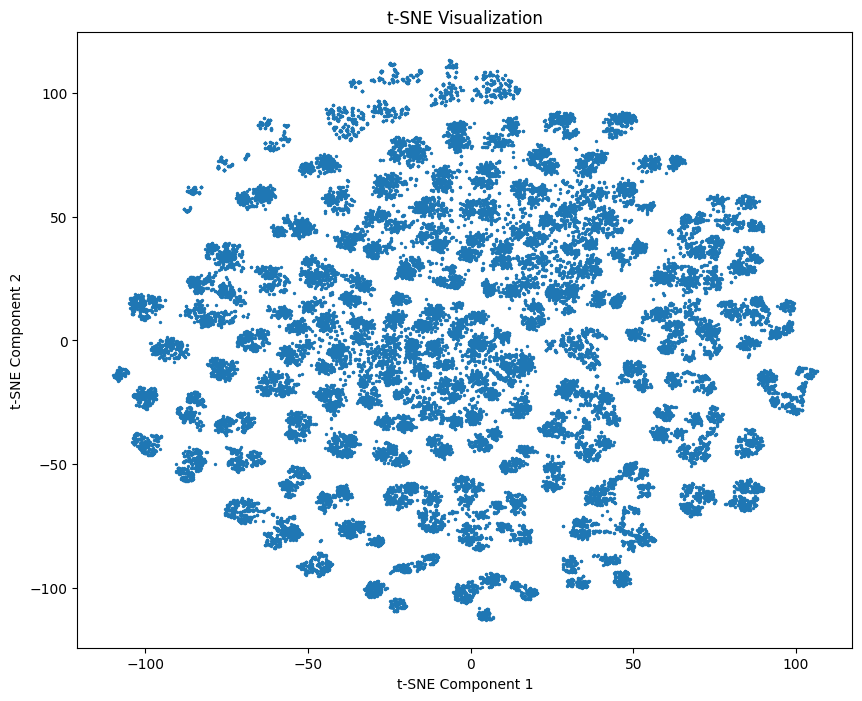

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], s=2, cmap='tab20')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [24]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_array)

In [ ]:
# Plot t-SNE with labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=encoded_labels, s=5, cmap='tab20')
cbar = plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)
plt.title('t-SNE Visualization Colored by Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Retain 95% of variance
pca = PCA(n_components=0.95)
x_reduced_pca = pca.fit_transform(features_array)
print("Reduced shape:", x_reduced_pca.shape)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(x_reduced_pca[:, 0], x_reduced_pca[:, 1], s=2, cmap='tab20')
plt.title('PCA Visualization with 2 Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


In [ ]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(features_array)

# Plot PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=encoded_labels, s=5, cmap='tab20')
""" plt.colorbar()
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show() """
# Create the colorbar with class names
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(label_encoder.classes_)))  # Set ticks to the number of classes
cbar.set_ticklabels(label_encoder.classes_)  # Replace ticks with the class names

plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
# Apply UMAP
reducer = umap.UMAP( n_neighbors=30,  n_components=2)
umap_result = reducer.fit_transform(features_array)

# Plot UMAP
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=encoded_labels, s=5, cmap='tab20')
plt.colorbar()
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


In [ ]:
reducer = umap.UMAP(n_neighbors=30, n_components=2, random_state=42)
umap_result = reducer.fit_transform(features_array)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=encoded_labels, s=5, cmap='tab20')
cbar = plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

# Set plot titles and labels
plt.title('UMAP Visualization Colored by Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_array)

reducer = umap.UMAP(n_neighbors=30, n_components=2)
umap_result = reducer.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=encoded_labels, s=5, cmap='tab20')
cbar = plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

# Set plot titles and labels
plt.title('UMAP Visualization Colored by Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
reducer = umap.UMAP(n_neighbors=30, metric='cosine')
umap_result = reducer.fit_transform(features_array)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=encoded_labels, s=5, cmap='tab20')
cbar = plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

# Set plot titles and labels
plt.title('UMAP Visualization Colored by Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
""" # Compute pairwise Euclidean distances
distances = pairwise_distances(features_array, metric='euclidean')

# Plot as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distances, cmap='coolwarm')
plt.title('Pairwise Distance Heatmap')
plt.show() """


In [ ]:
# Select a feature index to visualize its distribution
feature_index = 0  # Example: first feature

# Plot a histogram or KDE plot of the feature values for different labels
plt.figure(figsize=(10, 8))
for label in np.unique(labels_array):
    sns.kdeplot(features_array[labels_array == label, feature_index], label=label)
plt.title(f'Distribution of Feature {feature_index}')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3)
x_reduced_3d = tsne_3d.fit_transform(features_array)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_reduced_3d[:, 0], x_reduced_3d[:, 1], x_reduced_3d[:, 2], c=encoded_labels, cmap='tab20', s=50)
cbar = plt.colorbar(scatter)

# Set tick labels to the actual class names
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

# Set plot title and labels
plt.title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')


In [ ]:
""" corr_matrix = np.corrcoef(features_array)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show() """


In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(features_array)

# Plot t-SNE with clusters
plt.figure(figsize=(10, 8))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=cluster_labels, s=5, cmap='tab10')
plt.title('t-SNE with K-Means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
from minisom import MiniSom

som = MiniSom(x=10, y=10, input_len=features_array.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(features_array)
som.train_random(features_array, 100)  # Train with 100 iterations

plt.figure(figsize=(10, 8))
plt.pcolor(som.distance_map().T, cmap='Blues')  # Plot distance map
plt.colorbar()
plt.title('Self-Organizing Map Distance Map')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_array, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(features_array, 'ward')

plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title('Dendrogram of Feature Vectors')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
sns.heatmap(np.mean(features_array, axis=0).reshape(-1, 1), cmap='coolwarm', annot=True)
plt.title('Average Feature Activation')
plt.show()
